In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
for X, y in trainloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 3, 32, 32])
Shape of y:  torch.Size([256]) torch.int64


In [7]:
# VGG 16
import torchvision.models as models
import torch.nn as nn

vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)
# pretrained=True とすると，学習済みポラメータも読み込まれる．
# ~/.cache/torch/checkpoints/ に読み込まれます．VGG16は550MBもあるので，不要になったら消去しましょう．
# ls でダウンロードされていることを確認してみます．
! ls -l ~/.cache/torch/checkpoints/ 

合計 1247504
-rw------- 1 yang-j YANAI_LAB  46827520  4月 30 10:01 resnet18-5c106cde.pth
-rw------- 1 yang-j YANAI_LAB 102502400  4月 21 19:12 resnet50-19c8e357.pth
-rw------- 1 yang-j YANAI_LAB 553433881  4月 26 16:59 vgg16-397923af.pth
-rw------- 1 yang-j YANAI_LAB 574673361  4月 29 19:26 vgg19-dcbb9e9d.pth


In [16]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
vgg16fc7 = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-3]  # 最後の3つのlayer(relu,dropout,fc1000)を削除
)
# 表示してみます．fc7 (fc4096)が最終出力になっているはずです．
print(vgg16fc7)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)


Linear(in_features=25088, out_features=4096, bias=True) ReLU(inplace=True) Dropout(p=0.5, inplace=False) Linear(in_features=4096, out_features=4096, bias=True) ReLU(inplace=True) Dropout(p=0.5, inplace=False) Linear(in_features=4096, out_features=1000, bias=True)


In [33]:
# extract 100 images' feature
dataiter = iter(testloader)
images, labels = dataiter.next()

vgg16fc7 = vgg16fc7.to(device)

vgg16fc7.eval()
with torch.no_grad():
    fc=vgg16fc7(images.to(device)).cpu().numpy()
    # gpuで処理した結果を cpuに戻して，numpy形式にします．
print(fc.shape)     # shapeの表示


(100, 4096)


In [35]:
import pickle
# save fc feature
with open('fc4096.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(fc, f)

# 1.4096 demension clusetering

size of the 0 th cluster is 11
size of the 1 th cluster is 40
size of the 2 th cluster is 1
size of the 3 th cluster is 3
size of the 4 th cluster is 15
size of the 5 th cluster is 7
size of the 6 th cluster is 1
size of the 7 th cluster is 2
size of the 8 th cluster is 4
size of the 9 th cluster is 16


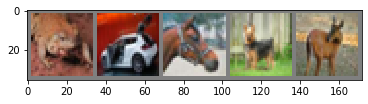

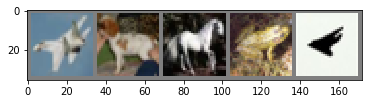

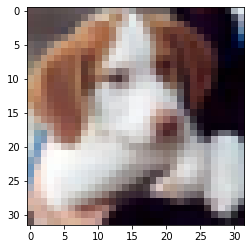

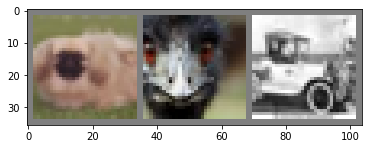

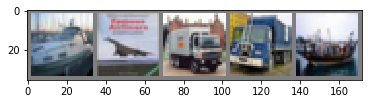

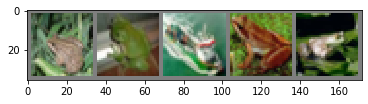

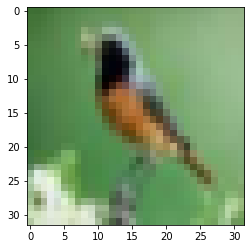

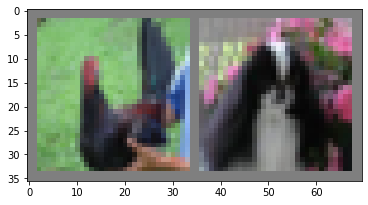

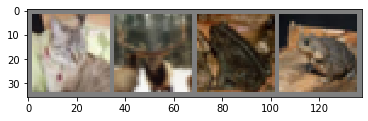

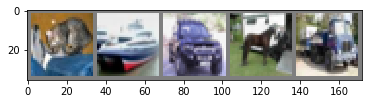

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# k = 10 
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(fc)

list = []

for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))


size of the 0 th cluster is 11
size of the 1 th cluster is 12
size of the 2 th cluster is 50
size of the 3 th cluster is 1
size of the 4 th cluster is 26


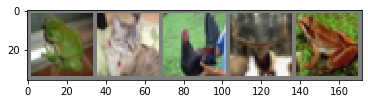

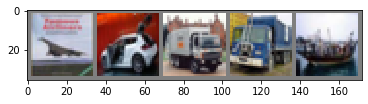

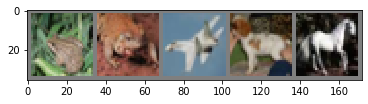

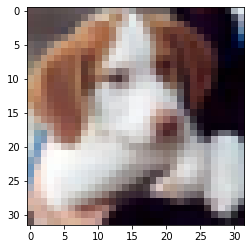

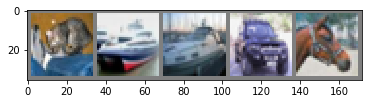

In [41]:
# change the cluster_num to clustering
cluster_num = 5
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(fc)

list = []

for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))

# 2. 寄与率95%の次元

In [117]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(fc.T)
print(pca.components_.shape)
print(f'累積寄与率：{sum(pca.explained_variance_ratio_)}')

fc_pca = pca.components_.T

print(f'圧縮した次元：{fc_pca.shape[1]}')

(40, 100)
累積寄与率：0.9521975107491016
圧縮した次元：40


size of the 0 th cluster is 32
size of the 1 th cluster is 18
size of the 2 th cluster is 4
size of the 3 th cluster is 1
size of the 4 th cluster is 2
size of the 5 th cluster is 9
size of the 6 th cluster is 14
size of the 7 th cluster is 2
size of the 8 th cluster is 8
size of the 9 th cluster is 10


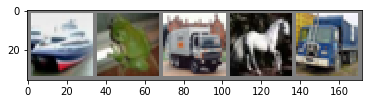

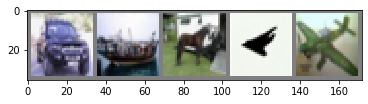

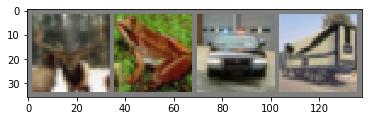

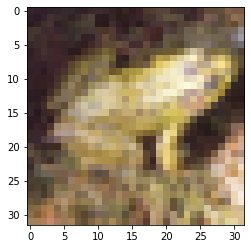

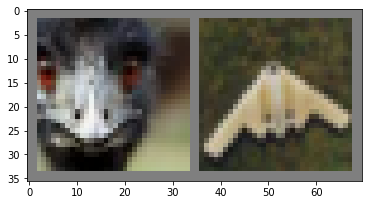

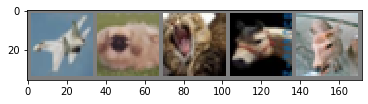

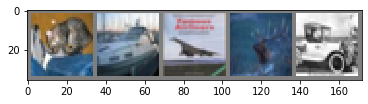

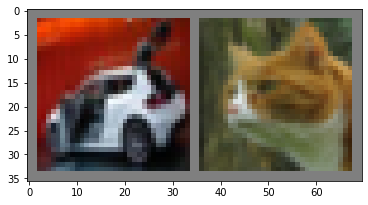

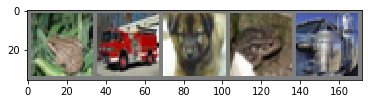

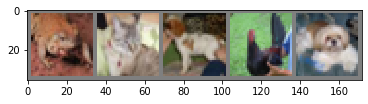

In [130]:
# change the cluster_num to clustering
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(fc_pca)

list = []

for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))

# 3. 寄与率90%の次元

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca.fit(fc.T)
print(pca.components_.shape)
print(f'累積寄与率：{sum(pca.explained_variance_ratio_)}')

fc_pca = pca.components_.T

print(f'圧縮した次元：{fc_pca.shape[1]}')

(28, 100)
累積寄与率：0.9055680548772216
圧縮した次元：28


size of the 0 th cluster is 32
size of the 1 th cluster is 18
size of the 2 th cluster is 4
size of the 3 th cluster is 1
size of the 4 th cluster is 2
size of the 5 th cluster is 9
size of the 6 th cluster is 14
size of the 7 th cluster is 2
size of the 8 th cluster is 8
size of the 9 th cluster is 10


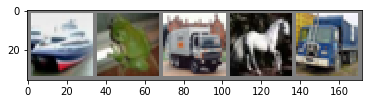

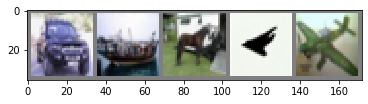

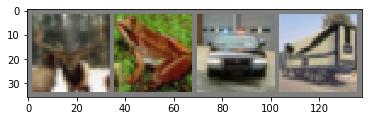

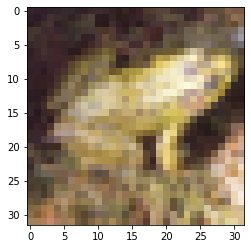

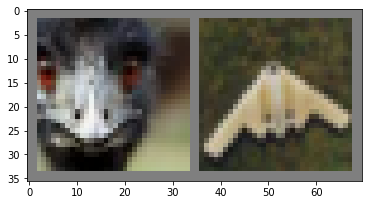

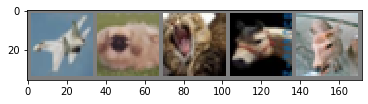

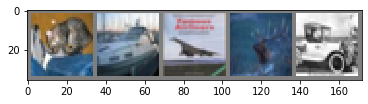

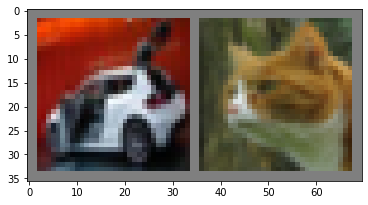

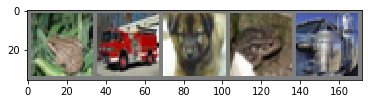

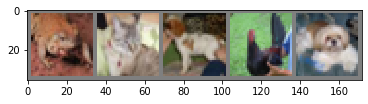

In [129]:
# change the cluster_num to clustering
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(fc_pca)

list = []

for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))

# 4. 100次元

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)
pca.fit(fc.T)
print(f'累積寄与率：{sum(pca.explained_variance_ratio_)}')

fc_pca = pca.components_.T

print(f'圧縮した次元：{fc_pca.shape[1]}')

累積寄与率：1.0000000176150934
圧縮した次元：100


size of the 0 th cluster is 32
size of the 1 th cluster is 18
size of the 2 th cluster is 4
size of the 3 th cluster is 1
size of the 4 th cluster is 2
size of the 5 th cluster is 9
size of the 6 th cluster is 14
size of the 7 th cluster is 2
size of the 8 th cluster is 8
size of the 9 th cluster is 10


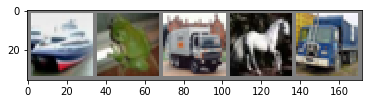

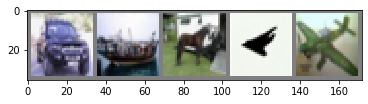

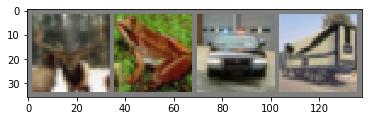

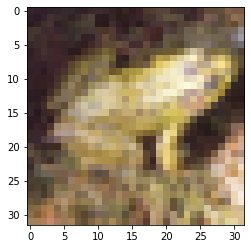

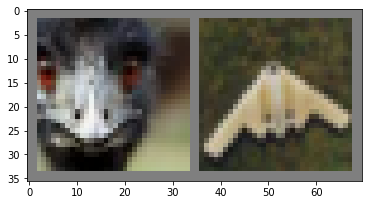

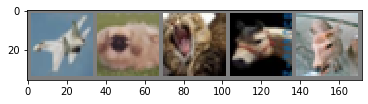

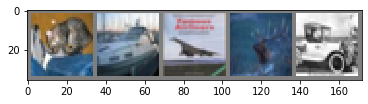

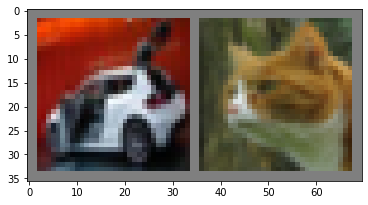

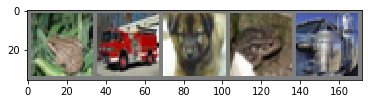

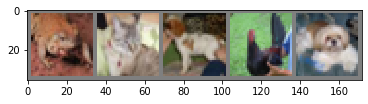

In [131]:
# change the cluster_num to clustering
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(fc_pca)

list = []

for i in range(cluster_num):
    temp = [idx for idx, val in enumerate(kmeans.labels_) if val == i]
    list.append(temp)
    print(f'size of the %d th cluster is %d' % (i, len(temp)))
    
for i in range(cluster_num):
    imshow(torchvision.utils.make_grid(images[list[i][0: min(5, len(list[i]))]]))